In [184]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, ConvLSTM2D




In [185]:
##########################################################
#Setting up the data frame

tf.random.set_seed(1234)
df = pd.read_csv("correct_water_data.csv")
df = df[df['date'] < '2021-01-01']

In [186]:
######################################################
# Splitting data into test,train 
# train data upto : 2012
# test : 2012-2019
train_data = df[df['date'] < '2013-01-01']
test_data = df[df['date'] >= '2013-01-01']

######################################################
#Data transformation 

train_x = train_data.loc[:, train_data.columns != 'precipitation'] #features
train_x = train_x.loc[:, ['np','SST.y','VWC1','VWC2','VWC4','hurr','SST.x','icec','whwp','tni']]


train_y = train_data['precipitation']

test_x = test_data.loc[:, test_data.columns != 'precipitation'] #features
test_x = test_x.loc[:, ['np','SST.y','VWC1','VWC2','VWC4','hurr','SST.x','icec','whwp','tni']]

test_y = test_data['precipitation']


In [187]:
######################################################
#Input Creation 
                   
min_max_scaler = MinMaxScaler()

train_x_scaled = min_max_scaler.fit_transform(train_x)
test_x_scaled = min_max_scaler.fit_transform(test_x)


def create_dataset(X,Y,look_back = 5):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        
        Xs.append(X[i: i+look_back])
        ys.append(Y[i: i+look_back])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_x_scaled,train_y)
X_test, y_test = create_dataset(test_x_scaled, test_y)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)


X_train.shape:  (367, 5, 10)
y_train.shape:  (367, 5)
X_test.shape:  (91, 5, 10)
y_test.shape:  (91, 5)


In [188]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.25))
    # Hidden layer
    model.add(GRU (units = units, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='sgd',loss='huber')
    return model

model_bilstm = create_bilstm(5)# Create GRU model


In [189]:
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    
    model.add(Dropout(0.25))
    # Hidden layer
    #model.add(GRU(units = units)) 
    model.add(Bidirectional(
              LSTM(units = units)))
    model.add(Dropout(0.25))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='sgd',loss='huber')
    return model

model_gru = create_gru(5)



In [190]:
[X_train.shape[1], X_train.shape[2]]

[5, 10]

In [191]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 200,  
                        validation_split = 0.2,
                        batch_size = 1, shuffle = True)
    return history


 #y_test = min_max_scaler.inverse_transform(y_test)
 #y_train = min_max_scaler.inverse_transform(y_train)


In [192]:
history_gru = fit_model(model_gru)

Epoch 1/200
293/293 [==============================] - 11s 13ms/step - loss: 75.2851 - val_loss: 58.4212
Epoch 2/200
293/293 [==============================] - 2s 7ms/step - loss: 69.5861 - val_loss: 54.7462
Epoch 3/200
293/293 [==============================] - 2s 7ms/step - loss: 66.9869 - val_loss: 53.5810
Epoch 4/200
293/293 [==============================] - 2s 7ms/step - loss: 65.4380 - val_loss: 53.1249
Epoch 5/200
293/293 [==============================] - 2s 7ms/step - loss: 64.5573 - val_loss: 52.9312
Epoch 6/200
293/293 [==============================] - 2s 7ms/step - loss: 64.8721 - val_loss: 52.8460
Epoch 7/200
293/293 [==============================] - 2s 7ms/step - loss: 64.7294 - val_loss: 52.7734
Epoch 8/200
293/293 [==============================] - 2s 7ms/step - loss: 64.5629 - val_loss: 52.7141
Epoch 9/200
293/293 [==============================] - 2s 7ms/step - loss: 64.3284 - val_loss: 52.6872
Epoch 10/200
293/293 [==============================] - 2s 7ms/step - l

In [193]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/200
293/293 [==============================] - 22s 14ms/step - loss: 74.9617 - val_loss: 58.1659
Epoch 2/200
293/293 [==============================] - 2s 7ms/step - loss: 70.3824 - val_loss: 55.5911
Epoch 3/200
293/293 [==============================] - 2s 6ms/step - loss: 67.9681 - val_loss: 54.3068
Epoch 4/200
293/293 [==============================] - 2s 7ms/step - loss: 66.5060 - val_loss: 53.6270
Epoch 5/200
293/293 [==============================] - 2s 6ms/step - loss: 65.6452 - val_loss: 53.2975
Epoch 6/200
293/293 [==============================] - 2s 7ms/step - loss: 65.0548 - val_loss: 53.0940
Epoch 7/200
293/293 [==============================] - 2s 6ms/step - loss: 65.3508 - val_loss: 52.9809
Epoch 8/200
293/293 [==============================] - 2s 7ms/step - loss: 64.7423 - val_loss: 52.9106
Epoch 9/200
293/293 [==============================] - 2s 7ms/step - loss: 64.5082 - val_loss: 52.8484
Epoch 10/200
293/293 [==============================] - 2s 7ms/step - l

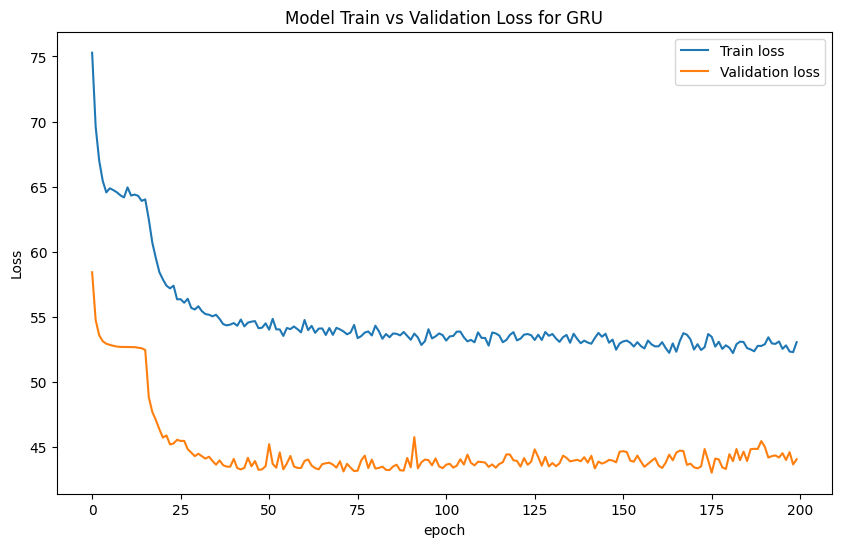

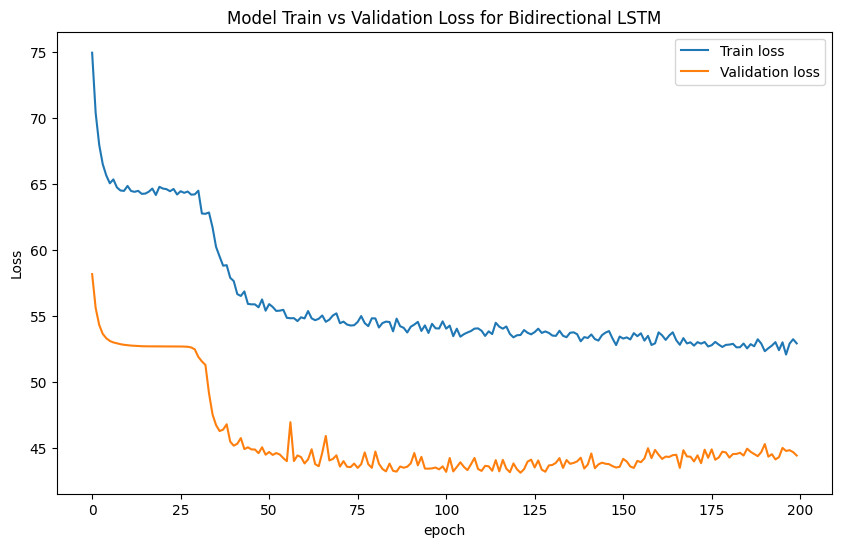

In [194]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')



In [160]:
def prediction(model):
    return model.predict(X_test)
    #prediction = scaler.inverse_transform(prediction)
    
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)


print("GRU",prediction_gru)
print("BILSTM", prediction_bilstm)




3/3 [==============================] - 2s 5ms/step
GRU [[ 76.835144 ]
 [ 64.49456  ]
 [ 39.520878 ]
 [ 14.283464 ]
 [ 11.014067 ]
 [  5.6688366]
 [ 14.440399 ]
 [ 59.60228  ]
 [120.123146 ]
 [147.61821  ]
 [144.23434  ]
 [127.98247  ]
 [107.02166  ]
 [ 63.61845  ]
 [ 36.803963 ]
 [ 13.519354 ]
 [ 10.871427 ]
 [  7.3422976]
 [ 13.435566 ]
 [ 29.471233 ]
 [ 69.37571  ]
 [ 79.74701  ]
 [ 83.47524  ]
 [ 81.55349  ]
 [ 59.19248  ]
 [ 35.30178  ]
 [ 12.494324 ]
 [  8.865259 ]
 [  8.477436 ]
 [ 12.215643 ]
 [  9.918391 ]
 [ 15.741314 ]
 [ 29.89983  ]
 [ 53.254272 ]
 [ 87.42345  ]
 [107.24232  ]
 [ 94.70885  ]
 [ 67.69645  ]
 [ 42.489105 ]
 [ 17.797201 ]
 [  7.2384334]
 [ 10.72856  ]
 [ 14.806231 ]
 [ 19.358095 ]
 [ 39.662582 ]
 [ 94.81753  ]
 [124.366554 ]
 [ 94.519135 ]
 [ 76.23802  ]
 [ 65.670006 ]
 [ 45.688747 ]
 [ 20.654152 ]
 [ 11.131311 ]
 [  8.672052 ]
 [  9.927771 ]
 [ 16.694641 ]
 [ 41.124374 ]
 [ 85.307465 ]
 [ 66.92318  ]
 [ 63.1492   ]
 [ 53.118473 ]
 [ 31.658308 ]
 [ 19.473139 ]


In [173]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

print(prediction_gru.shape)
prediction_gru = prediction_gru.flatten()
prediction_bilstm = prediction_bilstm.flatten()
evaluate_prediction(prediction_gru, test_y[1:len(test_y) - 4], 'GRU')
evaluate_prediction(prediction_bilstm, test_y[1:len(test_y) - 4], 'Bidirectiona LSTM')

(91,)
GRU:
Mean Absolute Error: 51.4837
Root Mean Square Error: 81.3090

Bidirectiona LSTM:
Mean Absolute Error: 47.9983
Root Mean Square Error: 72.7079



In [174]:
obtainedResultg = np.array([])
actualResultg = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_gru) or a > len(prediction_gru)):
        break
    temp1 = prediction_gru[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResultg = np.concatenate((obtainedResultg, temp1))
    actualResultg = np.concatenate((actualResultg, temp2))
    


In [175]:
evaluate_prediction(obtainedResultg, actualResultg, 'Winter Range GRU')

Winter Range GRU:
Mean Absolute Error: 68.5471
Root Mean Square Error: 93.2019



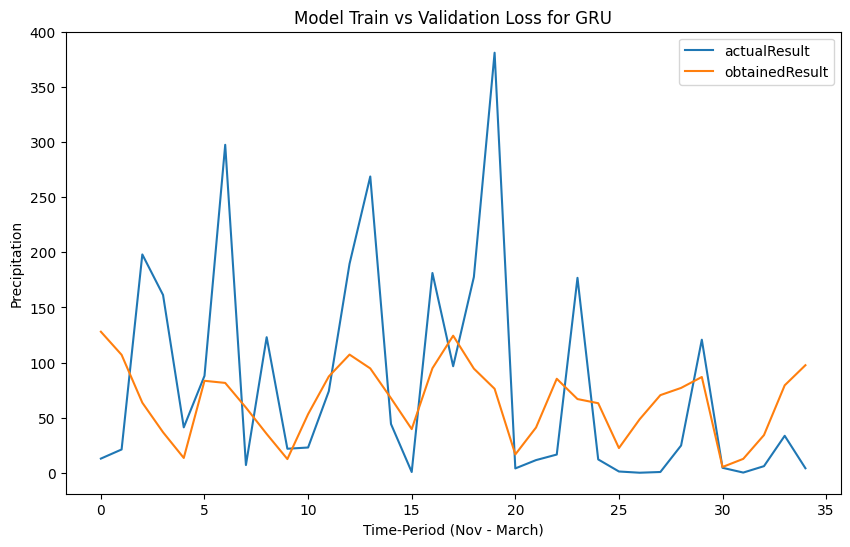

In [183]:
plt.figure(figsize = (10, 6))
plt.plot(actualResultg)
plt.plot(obtainedResultg)
plt.title('Model Train vs Validation Loss for GRU' )
plt.ylabel('Precipitation')
plt.xlabel('Time-Period (Nov - March)')
plt.legend(['actualResult', 'obtainedResult'], loc='upper right')

In [178]:
obtainedResult = np.array([])
actualResult = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_bilstm) or a > len(prediction_bilstm)):
        break
    temp1 = prediction_bilstm[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResult = np.concatenate((obtainedResult, temp1))
    actualResult = np.concatenate((actualResult, temp2))

In [179]:
evaluate_prediction(obtainedResult, actualResult, 'Winter Range LSTM')

Winter Range LSTM:
Mean Absolute Error: 63.1972
Root Mean Square Error: 83.0768



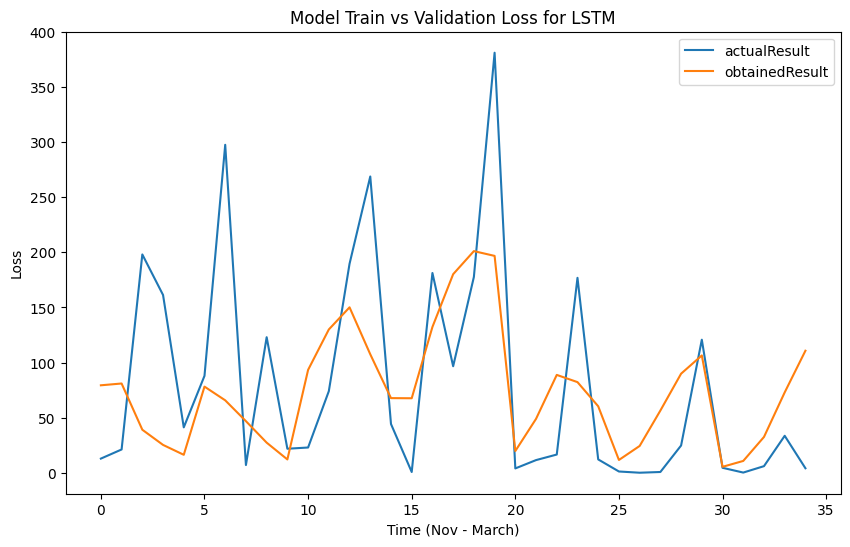

In [180]:
plt.figure(figsize = (10, 6))
plt.plot(actualResult)
plt.plot(obtainedResult)
plt.title('Model Train vs Validation Loss for LSTM' )
plt.ylabel('Loss')
plt.xlabel('Time (Nov - March)')
plt.legend(['actualResult', 'obtainedResult'], loc='upper right')

In [181]:
for index,data in enumerate(obtainedResultg):
    print(str(obtainedResultg[index]) + "," + str(actualResultg[index]))

127.98246765136719,12.9292
107.02165985107422,21.1996
63.61845016479492,198.0503
36.80396270751953,161.3026
13.519353866577148,41.2507
83.4752426147461,87.9625
81.5534896850586,297.4748
59.19247817993164,7.0892
35.301780700683594,123.0254
12.49432373046875,21.8603
53.2542724609375,22.9831
87.42344665527344,74.0655
107.24231719970703,189.5778
94.70884704589844,268.7216
67.69644927978516,44.3011
39.66258239746094,0.7685
94.8175277709961,181.2137
124.3665542602539,96.6702
94.51913452148438,177.6215
76.23802185058594,380.962
16.69464111328125,4.0216
41.12437438964844,11.5704
85.30746459960938,16.6042
66.92317962646484,176.8425
63.149200439453125,12.1807
22.47902488708496,1.2335
48.591312408447266,0.1221
70.47467041015625,0.7819
77.01756286621094,24.802
86.93423461914062,120.7473
5.321840763092041,4.5853
12.688237190246582,0.2598
34.26182174682617,6.0749
79.37104034423828,33.5986
97.61785888671875,4.1724


In [182]:
for index,data in enumerate(obtainedResult):
    print(str(obtainedResult[index]) + "," + str(actualResult[index]))

79.39868927001953,12.9292
81.02265167236328,21.1996
39.1031494140625,198.0503
25.34544563293457,161.3026
16.370208740234375,41.2507
78.20088958740234,87.9625
65.76956176757812,297.4748
46.869903564453125,7.0892
27.397233963012695,123.0254
12.163654327392578,21.8603
93.37930297851562,22.9831
130.01492309570312,74.0655
150.0973358154297,189.5778
107.53478240966797,268.7216
67.76811981201172,44.3011
67.6412124633789,0.7685
132.29933166503906,181.2137
180.13328552246094,96.6702
201.06265258789062,177.6215
196.7332305908203,380.962
19.803983688354492,4.0216
48.968650817871094,11.5704
88.81757354736328,16.6042
82.27568054199219,176.8425
60.36835479736328,12.1807
11.685629844665527,1.2335
24.396434783935547,0.1221
56.49359130859375,0.7819
89.92524719238281,24.802
106.47714233398438,120.7473
5.471643447875977,4.5853
10.813955307006836,0.2598
32.55481719970703,6.0749
72.98160552978516,33.5986
110.74273681640625,4.1724
